In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.4.0'

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [5]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [6]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [7]:
words[:10]

['the lodge told the password and at last was permitted to sit down the',
 'him the french had advanced nearest on our right below the height on',
 'tilting yet further back why is it so long thought pierre it seemed',
 '',
 'the head that he was considering this information',
 'disorder he muttered do as you like',
 'energetically do we pursue this aim that after crossing an unfordable',
 'and it must seem to you said boris flushing slightly but not',
 'boris bowed again politely',
 '']

In [8]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [9]:
block_size = 8 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 8]), torch.int64, torch.Size([204978]), torch.int64)

In [11]:
emb_dim = 32
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[ 0.4022,  0.7373, -0.8243,  ...,  1.1109,  1.2069, -1.2826],
        [-1.5400, -1.2899, -1.1485,  ...,  1.0225,  0.5305, -0.8223],
        [ 0.2098,  0.1225,  1.2702,  ...,  0.1900,  1.1579,  1.4840],
        ...,
        [ 1.2846, -0.0718,  0.6871,  ..., -0.7610, -1.9250,  0.8116],
        [-0.4561,  0.6920,  2.3028,  ..., -0.5750,  0.6401, -0.3869],
        [-0.0125, -0.4103, -0.6423,  ...,  0.6332,  1.7457,  1.3744]],
       requires_grad=True)

In [12]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.tanh(self.lin1(x))
        x = self.lin2(x)
        return x 

In [13]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 1024).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1027 11:51:21.715000 133197552858944 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/2531494610.py line 8 
W1027 11:51:21.715000 133197552858944 torch/_dynamo/convert_frame.py:1009] due to: 
W1027 11:51:21.715000 133197552858944 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1027 11:51:21.715000 133197552858944 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1027 11:51:21.715000 133197552858944 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1027 11:51:21.715000 133197552858944 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1027 11:51:21.715000 133197552858944 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1027 11:51:21.715000 133197552858944 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 lessyes chance ceremoniously distributed shading inner pondered maintenance quality roles ended resources newly summon devise waltz papers career thumb cut hugged imperial connoisseurs unabashed wrath unfortunate key andre aptitude farther adroitness hoped creases caused bated century regretted rather ahing chaffingly tact responsive wellkept dyed repented befallen kuzmich selfpossession sparrow mouthpiece restrained midday comb portfolio sabretache foreheads hydra censure or complied petition greatest retired cloud mothers edifying dignity swelling possession bwushed alms tenths dandies thrusting patches andreevich evolutions showed interest stylish gaunt restive plumb gazed cossacks disperse fifty contrary mines blissful bedsteads hes frenchall baron chanced torch theres indifference abandoning indecorous
 restfully dulled smooth presented faithfully hurting habitual sera folly myself retinues dawn suitor closing hatred almighty blush convulsed annoyance chatter emphasis thin prizes

In [14]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

len(stoi)

_orig_mod.emb.weight torch.Size([11189, 32])
_orig_mod.lin1.weight torch.Size([1024, 256])
_orig_mod.lin1.bias torch.Size([1024])
_orig_mod.lin2.weight torch.Size([11189, 1024])
_orig_mod.lin2.bias torch.Size([11189])


11189

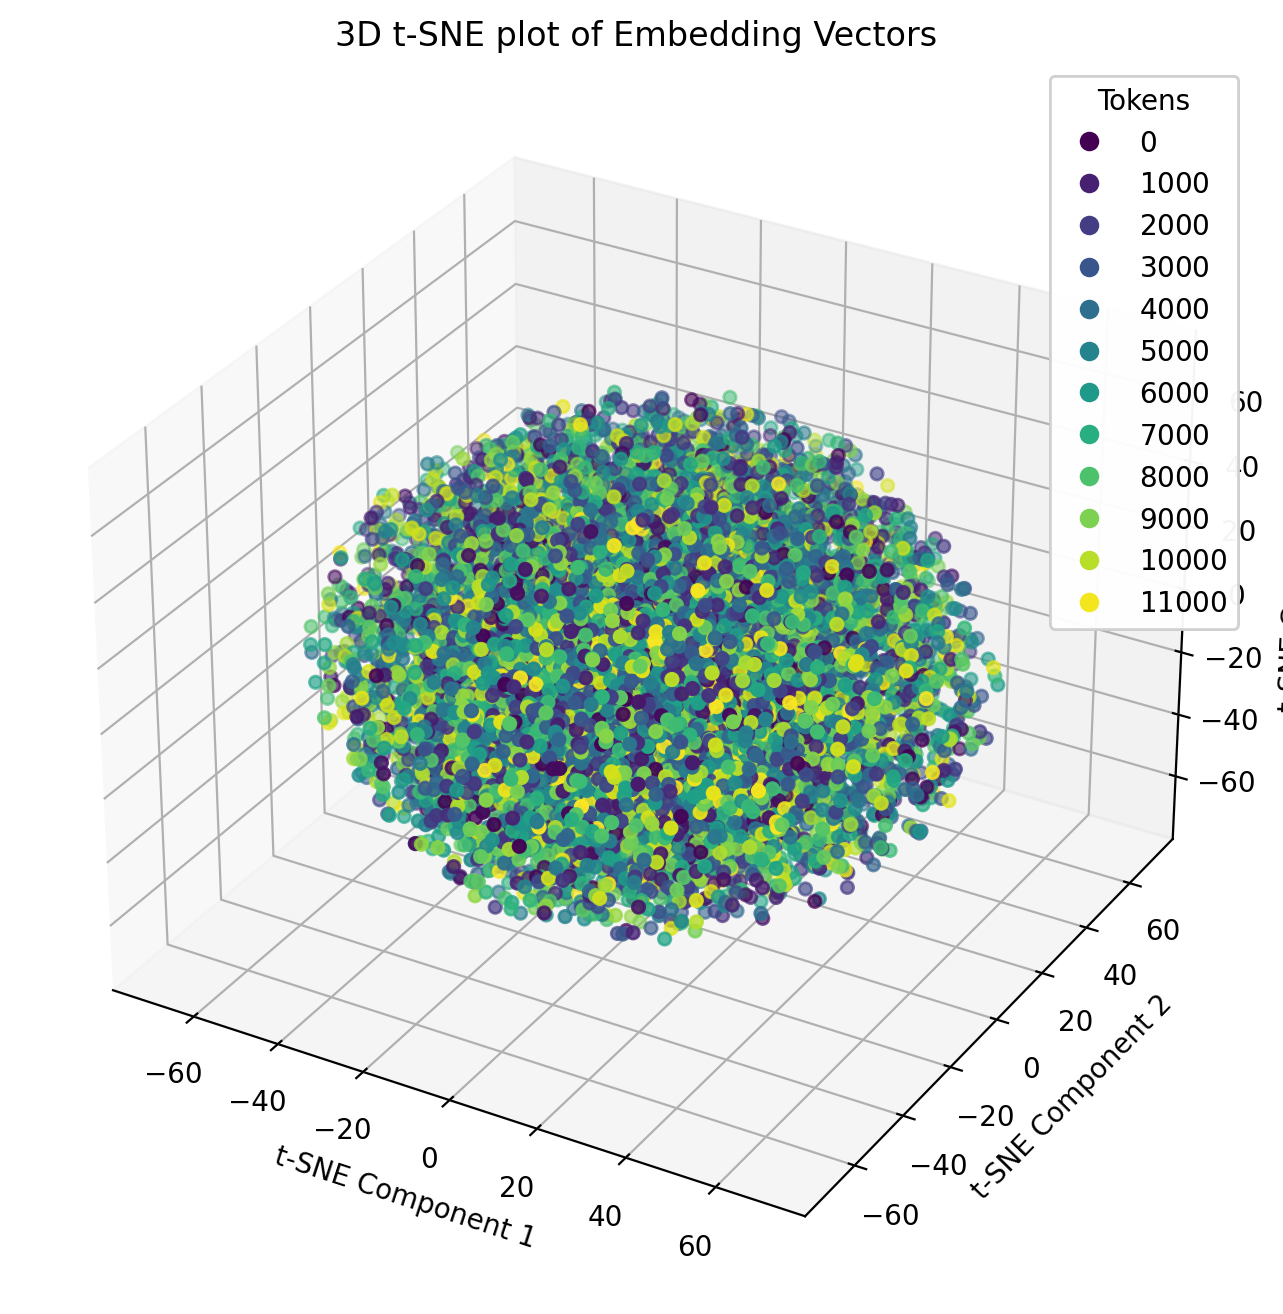

In [15]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 20 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

In [16]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(1000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass

Epoch 0, Loss: 11.461664199829102
Epoch 10, Loss: 8.716205596923828
Epoch 20, Loss: 7.835714340209961
Epoch 30, Loss: 7.25653076171875
Epoch 40, Loss: 6.821206569671631
Epoch 50, Loss: 6.462604522705078
Epoch 60, Loss: 6.146437644958496
Epoch 70, Loss: 5.858482837677002
Epoch 80, Loss: 5.593419551849365
Epoch 90, Loss: 5.349538326263428
Epoch 100, Loss: 5.126041412353516
Epoch 110, Loss: 4.922317028045654
Epoch 120, Loss: 4.737226486206055
Epoch 130, Loss: 4.569165229797363
Epoch 140, Loss: 4.416326522827148
Epoch 150, Loss: 4.276757717132568
Epoch 160, Loss: 4.148988723754883
Epoch 170, Loss: 4.0314178466796875
Epoch 180, Loss: 3.9229440689086914
Epoch 190, Loss: 3.8225510120391846
Epoch 200, Loss: 3.729318141937256
Epoch 210, Loss: 3.6424763202667236
Epoch 220, Loss: 3.561453342437744
Epoch 230, Loss: 3.485825538635254
Epoch 240, Loss: 3.414973258972168
Epoch 250, Loss: 3.348562240600586
Epoch 260, Loss: 3.2862465381622314
Epoch 270, Loss: 3.2277002334594727
Epoch 280, Loss: 3.172727

In [17]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 he thought of horses to look it across beside me lifted hundred and of the
 with their questions ribbons in the drawing room
 
 
 do you had so kind princess heavily and the old lady with a gold
 tiny you helped mortiers that you are demosthenes
 in my way he were more center military up the largest of this visit which did seemed to hugged or they were all their
 natasha sonya was a succeeds and his son
 
 voice from him that it was saying of his conversation he even more dark


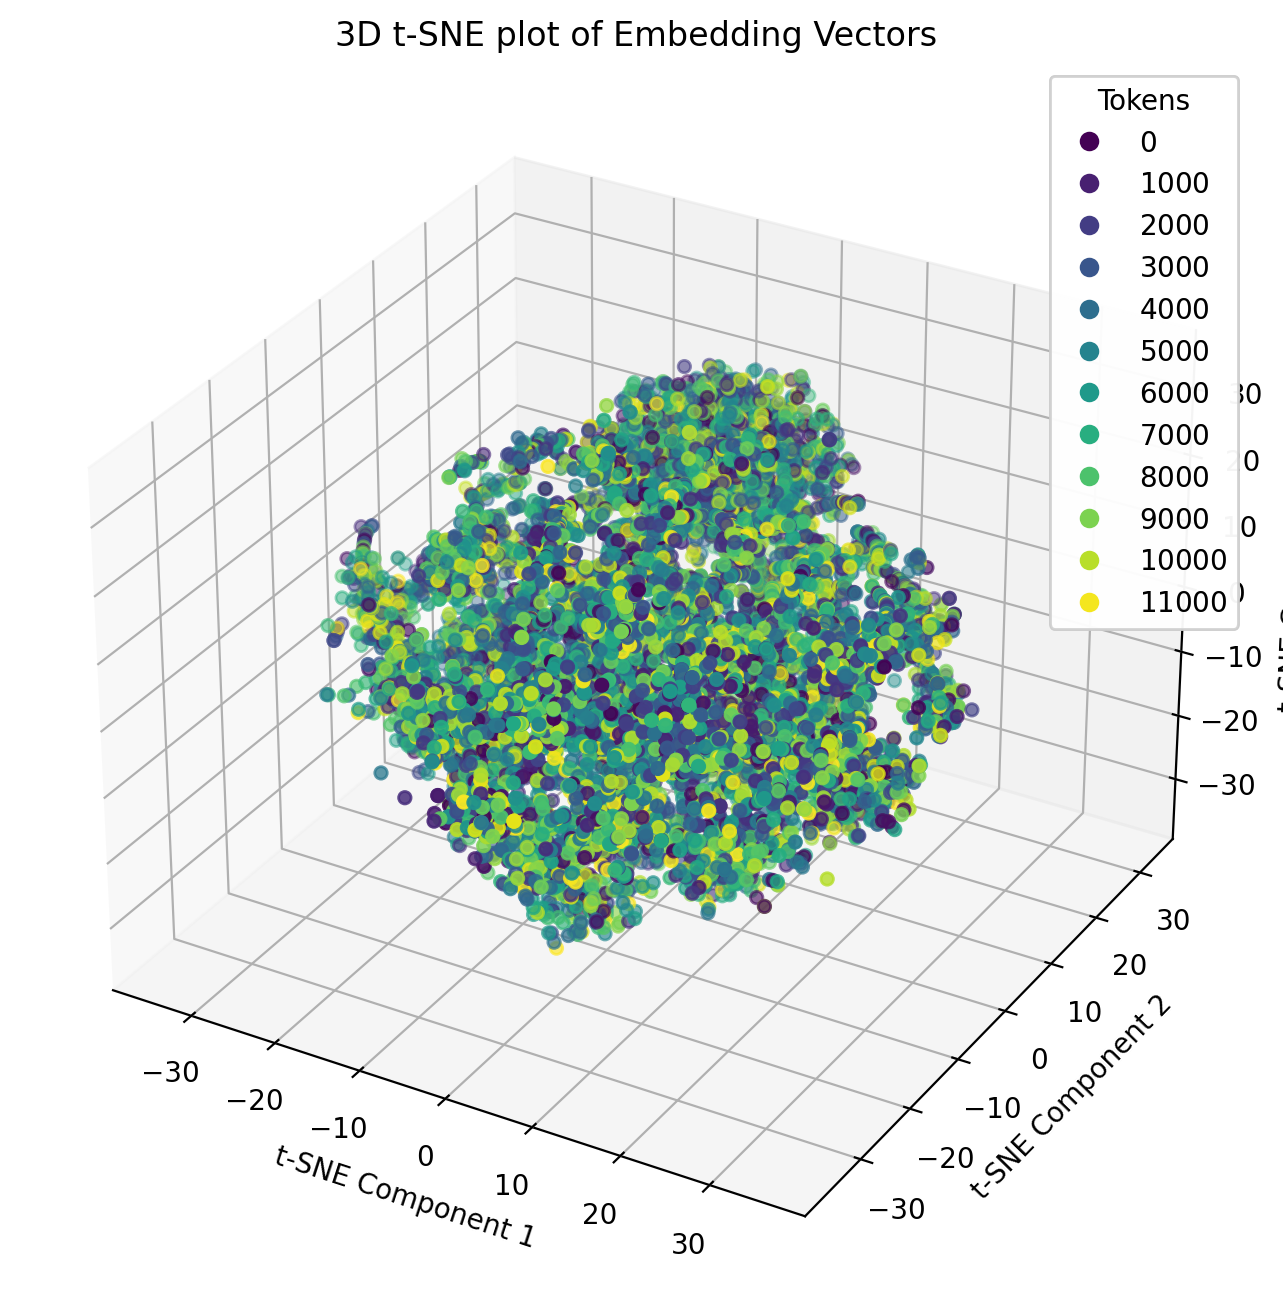

In [18]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 20 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [19]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_8_32_1024.pth")

In [20]:
model = model.to(device)